In [1]:
import sys;
import notebookutil;
sys.meta_path.append(notebookutil.NotebookFinder());
from bento_util import generate_predict;
from bento_util import draw_prediction_curve;
from bento_util import draw_learning_curve;
from bento_util import draw_pca_accumulation;
from bento_util import predict_cv;
from bento_util import RestrictedPCA;
from bento_util import NPCA;
from bento_data import load_data;
from bento_data import prepare_dataset;
from bento_data import menu_columns;

import math;
import pandas as pd;
import numpy as np;
import scipy as sp;
import matplotlib.pyplot as plot;
from sklearn.pipeline import Pipeline;
from sklearn.linear_model import LinearRegression;
from sklearn.linear_model import ElasticNet;
from sklearn.linear_model import Lasso;
from sklearn.svm import SVR;
from sklearn.ensemble import RandomForestRegressor;
%matplotlib inline

### 使えそうな特徴だけで線形回帰
* お弁当買う/買わないの意思決定要素は独立、誤差は正規分布しそう
* kcalは欠損値が多いので捨てる
* メニューもどうしてよいのかわからないので捨てる
* それ以外はダミー化する

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


estimator score: 0.618844989445


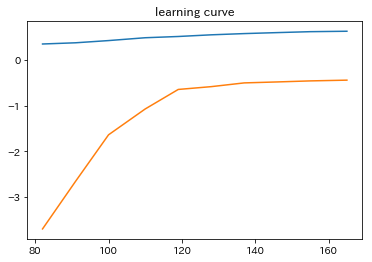

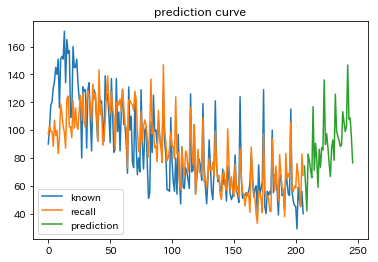

recall RMSE: 20.2517890602


In [2]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], menus=False, baselines=None);
regressor = LinearRegression();
predict_cv(regressor, None, X, y, target, "result/notes/note00.csv", n_iter=-1, print_scores=False);

→ イケてる感じはないがベースラインとして応募してみる。スコア43.33

### 非線形でやってみる
* SVMのRBFカーネル

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:   53.8s finished


best params: {'reg__gamma': 0.42000000000000004, 'reg__kernel': 'rbf', 'reg__C': 31.900000000000002}
estimator score: 0.828112576258


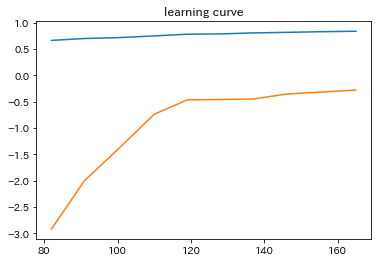

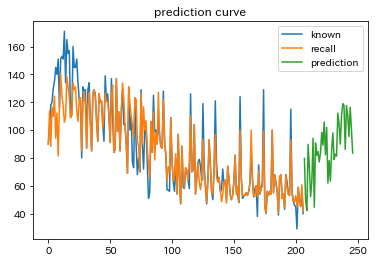

recall RMSE: 13.5998660153


In [3]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], menus=False, baselines=None);
regressor = Pipeline(steps=[
    ("reg", SVR(kernel="rbf", C=99.1, gamma=0.11)),
]);

param_dists = {
    "reg__kernel": ["rbf"],
    "reg__C": np.arange(0.1, 100.0, 0.1),
    "reg__gamma": np.arange(0.01, 10, 0.01),
};

predict_cv(regressor, param_dists, X, y, target, "result/notes/note01.csv", n_iter=1000, print_scores=False);

→ さっきより既知データにフィットしているがスコア42.64。想定値より高めに予測しすぎるのは古いデータの影響？

### 定常状態のデータだけ使ってみる
* 序盤はオープンしたばかりで人気があった？
* 100日目くらいまでは実力以上に売れてるっぽいので学習に使わない

estimator score: 0.703981890155


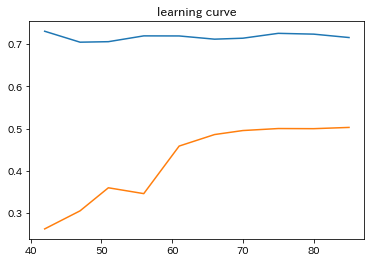

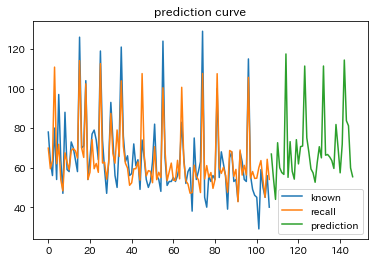

recall RMSE: 10.3846662255


In [4]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], n_chops=100, menus=False, baselines=None);
regressor = LinearRegression();
predict_cv(regressor, None, X, y, target, "result/notes/note02.csv", n_iter=-1, print_scores=False);

→ それっぽくて良さげだがスコア20.39。手抜き作戦失敗

### 長期的に右肩下がりになってるのを考慮する
* (スタート日からの経過日数を特徴量として追加)
* 長期傾向の差分をとってから学習する → bento_data-observation

estimator score: 0.43654789719


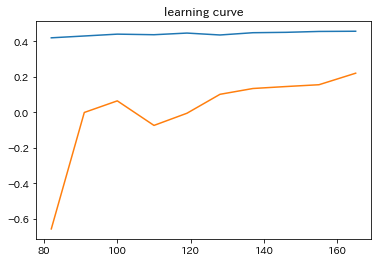

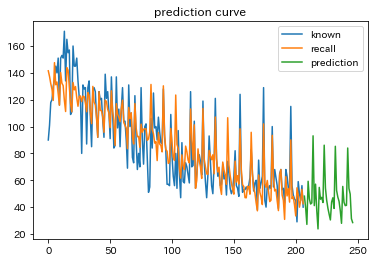

recall RMSE: 14.8524399089


In [5]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], menus=False, baselines={"stability": "exp"});
regressor = LinearRegression();
predict_cv(regressor, None, X, y, target, "result/notes/note03.csv", n_iter=-1, print_scores=False, y_offset=offset);

→ スコア8.85。爆上がり

### はじめのブロックを削除してみる
* 序盤の当てはまりが悪いデータを学習しない

estimator score: 0.561700188943


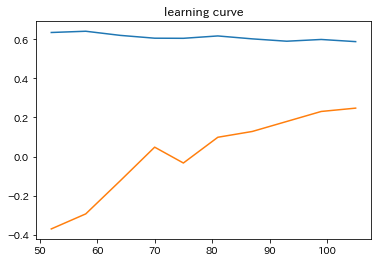

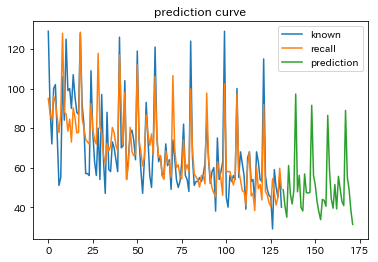

recall RMSE: 12.6661228719


In [6]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], n_chops=75, menus=False, baselines={"stability": "exp"});
regressor = LinearRegression();
predict_cv(regressor, None, X, y, target, "result/notes/note04.csv", n_iter=-1, print_scores=False, y_offset=offset);

→ スコア9.71。データ捨てないほうが良さそう

### 周期変動を考慮する（できなかった）
* 一年周期を正弦波で表現してみたりするもイマイチ
* 季節変動や月内の変動も要素としてありそう
* ~~面倒だったので~~モデリング根拠がないので諦めることにする

### メニューを頑張ってみる
* 各メニューを調理法、食材、味付け、雰囲気など多角的にタグ付け
* スパイクに効いてそうなので期待

estimator score: 0.496737950825


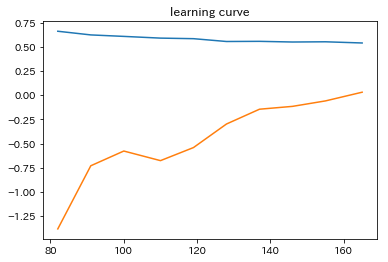

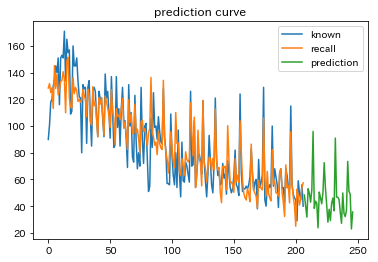

recall RMSE: 14.0367444321


In [7]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], menus=True, baselines={"stability": "exp"});
regressor = LinearRegression();
predict_cv(regressor, None, X, y, target, "result/notes/note08.csv", n_iter=-1, print_scores=False, y_offset=offset);

→ スコア11.60。かなりがんばったのに上がらない悲しさ

### 特徴量を減らしてみる
* メニュー処理を入れたら収束遅くなった
* 素性数が40を超えているのでPCA入れる
* メニュー特徴が多いので二段階で入れる

Fitting 5 folds for each of 546 candidates, totalling 2730 fits


[Parallel(n_jobs=1)]: Done 2730 out of 2730 | elapsed:   30.9s finished


best params: {'pca__n_components': 18, 'menu_pca__n_components': 1}
estimator score: 0.433107192193


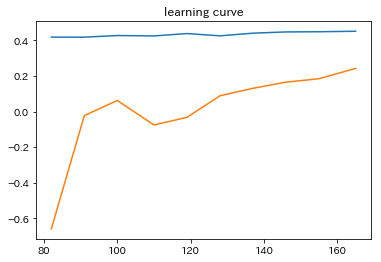

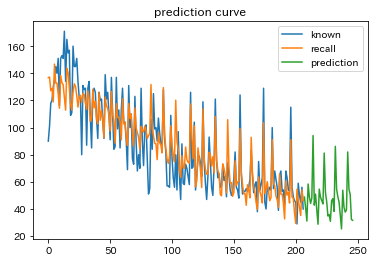

recall RMSE: 14.8977189013


In [8]:
X, y, target, offset = prepare_dataset(drop_columns=["kcal"], menus=True, baselines={"stability": "exp"});
regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", LinearRegression()),
]);
param_dists = {
    "menu_pca__n_components": np.arange(len(menu_columns) + 1),
    "pca__n_components": np.arange(len(X.columns) - (len(menu_columns) - 1)),
};

linear_best = predict_cv(regressor, param_dists, X, y, target, "result/notes/note09.csv", n_iter=-1, print_scores=False, y_offset=offset);

→ スコア8.52。よくなった＆収束早くなった

### アルゴリズム変えてみる
* 線形モデル
  * ElasticNet
  * SVMのLinearカーネル
* 非線形モデル
  * SVMのRBFカーネル
  * Random Forest

そういえば捨てていたkcalをそのまま使ってもエラーにならなそうなので使ってみる

Fitting 5 folds for each of 567 candidates, totalling 2835 fits


[Parallel(n_jobs=1)]: Done 2835 out of 2835 | elapsed:   27.8s finished


best params: {'pca__n_components': 19, 'menu_pca__n_components': 1}
estimator score: 0.469149494809


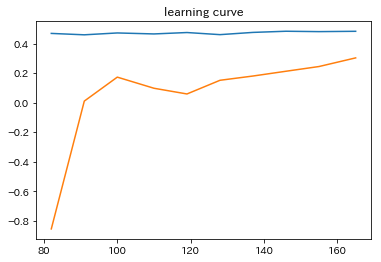

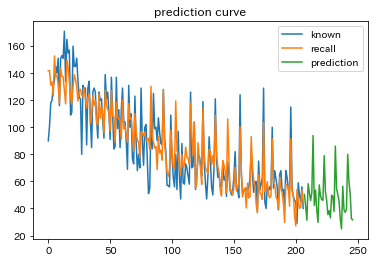

recall RMSE: 14.4163533818
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=1)]: Done 8100 out of 8100 | elapsed:  1.5min finished


best params: {'pca__n_components': 18, 'reg__l1_ratio': 0.95000000000000029, 'menu_pca__n_components': 1, 'reg__alpha': 0.10000000000000001}
estimator score: 0.453128290301


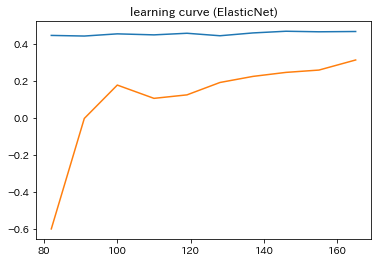

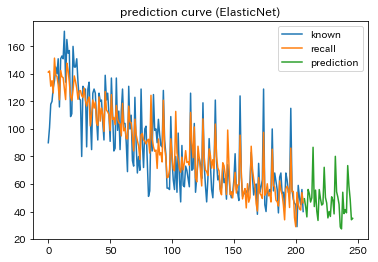

recall RMSE: 14.6322809277
Fitting 5 folds for each of 950 candidates, totalling 4750 fits


[Parallel(n_jobs=1)]: Done 4750 out of 4750 | elapsed:  1.1min finished


best params: {'pca__n_components': 19, 'reg__kernel': 'linear', 'menu_pca__n_components': 1, 'reg__C': 12.900000000000011}
estimator score: 0.442056079362


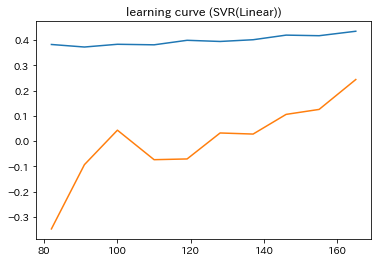

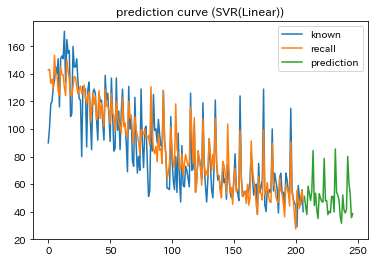

recall RMSE: 14.7796645421
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


best params: {'reg__gamma': 0.099999999999999992, 'pca__n_components': 15, 'reg__kernel': 'rbf', 'reg__C': 18.300000000000001, 'menu_pca__n_components': 1}
estimator score: 0.595973241414


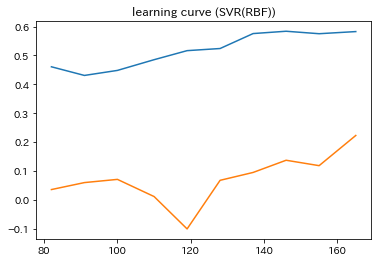

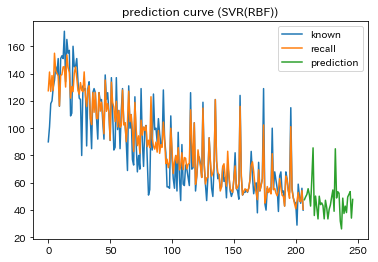

recall RMSE: 12.5769219732
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed: 68.9min finished


best params: {'reg__n_estimators': 500, 'pca__n_components': 19, 'reg__max_depth': 5, 'menu_pca__n_components': 1, 'reg__max_features': None}
estimator score: 0.741738329038


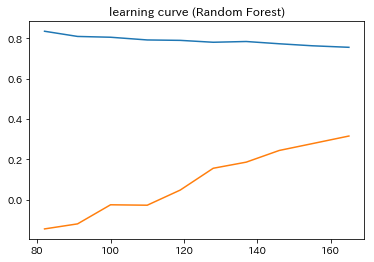

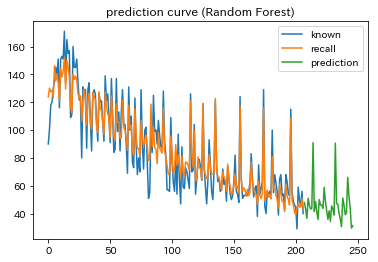

recall RMSE: 10.0553983537


In [12]:
X, y, target, offset = prepare_dataset();

regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", ElasticNet(alpha=0.2, l1_ratio=0.9)),
]);

param_dists = {
    "menu_pca__n_components": [1],
    "pca__n_components": np.arange(15, 20, 1),
    "reg__alpha": np.arange(0.1, 1.0, 0.05),
    "reg__l1_ratio": np.arange(0.1, 1.0, 0.05),
};

elastic_net_best = predict_cv(regressor, param_dists, X, y, target, "result/notes/note11.csv", n_iter=-1, print_scores=False, y_offset=offset, title="ElasticNet");

regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", SVR(kernel="linear", C=15)),
]);
param_dists = {
    "menu_pca__n_components": [1],
    "pca__n_components": np.arange(15, 20, 1),
    "reg__kernel": ["linear"],
    "reg__C": np.arange(1, 20.0, 0.1),
};

svr_linear_best = predict_cv(regressor, param_dists, X, y, target, "result/notes/note12.csv", n_iter=-1, print_scores=False, y_offset=offset, title="SVR(Linear)");

regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", SVR(kernel="rbf", C=99.1, gamma=0.11)),
]);

param_dists = {
    "menu_pca__n_components": [1],
    "pca__n_components": np.arange(15, 20, 1),
    "reg__kernel": ["rbf"],
    "reg__C": np.arange(0.1, 20.0, 0.1),
    "reg__gamma": np.arange(0.01, 10, 0.01),
};

svr_rbf_best = predict_cv(regressor, param_dists, X, y, target, "result/notes/note13.csv", n_iter=1000, print_scores=False, y_offset=offset, title="SVR(RBF)");

regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", RandomForestRegressor(n_estimators=1000, max_features=None, max_depth=10)),
]);

param_dists = {
    "menu_pca__n_components": [1],
    "pca__n_components": np.arange(15, 20, 1),
    "reg__n_estimators": [500],
    "reg__max_features": ["auto", "sqrt", "log2", None],
    "reg__max_depth": [None, 5, 10, 15],
};

rf_best = predict_cv(regressor, param_dists, X, y, target, "result/notes/note14.csv", n_iter=-1, print_scores=False, y_offset=offset, title="Random Forest");

→ スコア
* 線形モデル
  * ElasticNet: 8.39
  * SVM(Linear): 7.87 → BEST
* 非線形モデル
  * SVM(RBF): 14.84
  * Random Forest: 11.21

### おまけ：アンサンブルしてみる
* 複数の予測器の平均値を出力とする
  * 線形モデル
    * LinearRegression
    * ElasticNet
    * SVM(Linearカーネル)
  * 非線形モデル
    * SVM(RBFカーネル)
    * Random Forest

estimator score: 0.894730398827


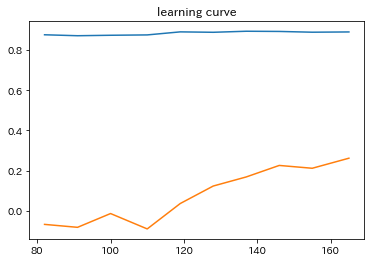

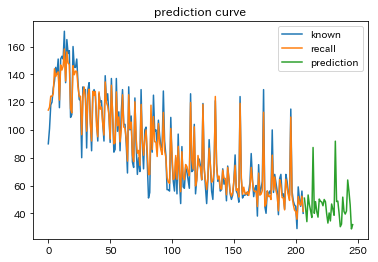

recall RMSE: 6.41978953847


In [13]:
from sklearn.base import BaseEstimator;
from sklearn.base import RegressorMixin;

'''
 複数のregressorの平均値を取る
'''
class AverageRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, regressors):
        self.regressors = regressors;

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y);

    def predict(self, X):
        predictions = None;
        for regressor in self.regressors:
            pred = regressor.predict(X)[:, np.newaxis];
            predictions = np.concatenate((predictions, pred), axis=1) if (predictions is not None) else pred;
        return np.average(predictions, axis=1);

X, y, target, offset = prepare_dataset();
regressors = [ linear_best, elastic_net_best, svr_linear_best, svr_rbf_best, rf_best ];
ensemble_regressor = AverageRegressor(regressors);
best_ensemble2 = predict_cv(regressor, None, X, y, target, "result/notes/note15.csv", n_iter=0, print_scores=False, y_offset=offset);

→ スコア11.94

### おまけ：アンサンブルしてみる(II)
* 複数の予測器の出力を線形回帰
  * 線形モデル
    * LinearRegression
    * ElasticNet
    * SVM(Linearカーネル)
  * 非線形モデル
    * SVM(RBFカーネル)
    * Random Forest

estimator score: 0.822063770227


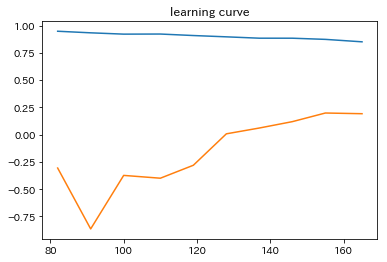

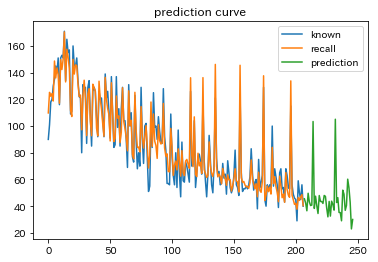

recall RMSE: 8.34644419599


In [14]:
'''
 複数のregressorの出力値で線形回帰する
'''
class EnsembleLinearRegressor(RegressorMixin, BaseEstimator):
    def __init__(self, regressors):
        self.regressors = regressors;
        self.reg = LinearRegression();

    def fit(self, X, y):
        x = None;
        for regressor in self.regressors:
            regressor.fit(X, y);
            rx = regressor.predict(X)[:, np.newaxis];
            x = np.concatenate((x, rx), axis=1) if (x is not None) else rx;
        self.reg.fit(x, y);

    def predict(self, X):
        predictions = None;
        for regressor in self.regressors:
            pred = regressor.predict(X)[:, np.newaxis];
            predictions = np.concatenate((predictions, pred), axis=1) if (predictions is not None) else pred;
        return self.reg.predict(predictions);

X, y, target, offset = prepare_dataset();
regressors = [ linear_best, elastic_net_best, svr_linear_best, svr_rbf_best, rf_best ];
el_regressor = EnsembleLinearRegressor(regressors);
predict_cv(el_regressor, None, X, y, target, "result/notes/note16.csv", n_iter=0, print_scores=False, y_offset=offset);

→ スコア14.05

# 考察
## 効いたもの
* 周期的変動要素のモデリング（変動分を差し引いて予測）
  * 長期的な販売数減少
* 特徴量削減
  * 学習データ数200 vs 特徴数40

## 効かなかったもの
* メニュー属性抽出
  * 一番がんばった...
* 非線形モデル
  * 複雑な写像にならないようにパラメータ制限/正則化すればいけるのかも
* アンサンブル
  * 補い合う要素がなかったのかも

## このテーマの難しさ
未知の事象に対する予測
* 長期的な変動が収束していないため、予測に対する不確定性が高い
* 一年分のデータがないため、季節変動に対して学習できない
  * 学習データ：2013/11/18〜2014/9/30（207日間）
  * 予測対象：2014/10/1〜2014/11/28（40日間）
  * 未知の大型イベントが予測対象に突然出てくる
    * 2014/11/13「近隣に飲食店複合ビルオープン」

## できなかったこと、わからなかったこと
* 現実の予測問題だった場合、どのモデルを運用に乗せるべきなのか
  * 未知データと学習データの傾向が違う or データ不足
    * CVスコアの良さと予測結果スコアの良さの傾向が一致しない
    * 非線形でフィットさせるとスコアが低い
  * ベストチューニングが信用できない
* 季節変動、月間変動（給与時期、ボーナス時期）
  * そもそもあるのかどうか不明
* 欠損値の補間
  * kcalがNaNの場合、どう扱うべきか
* 正弦波へのフィッティング
  * scipy.curve_fitの使い方？
* 特徴量選択が適当だった(PCA)
  * PCAでよいのか
    * 属性の組み合わせに意味がある場合、潰れてしまう？
  * メニューに関する特徴数が多いなど、特徴数に偏りがある場合にどうするか
  * 効いてなさそうな属性は手動で捨てる
    * あるととりあえず使いたくなる

## 以下、実験コード

In [ ]:
from pandas.tools.plotting import scatter_matrix;

X, y, target, offset = prepare_dataset();
scatter_matrix(X, diagonal='kde', color='k', alpha=0.3);
#X.plot(kind="scatter", x="menu_trendy", y="y");

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed: 54.2min finished


best params: {'reg__num_leaves': 292, 'pca__n_components': 0, 'reg__num_iterations': 500, 'menu_pca__n_components': 1, 'reg__learning_rate': 0.021956966275734728}
estimator score: 0.786265219592


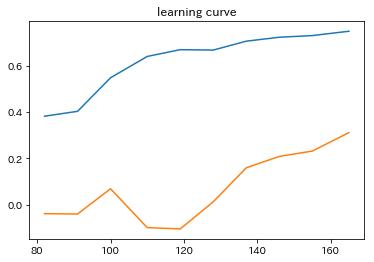

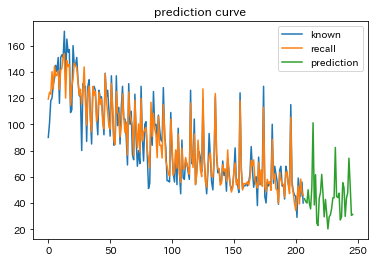

recall RMSE: 9.14759443487


In [19]:
from lightgbm import LGBMRegressor;
from scipy import stats;

X, y, target, offset = prepare_dataset();

regressor = Pipeline(steps=[
    ("menu_pca", RestrictedPCA(menu_columns, n_components=1)),
    ("pca", NPCA(n_components=14)),
    ("reg", LGBMRegressor(num_leaves=21297, num_iterations=100, learning_rate=0.14946)),
]);

param_dists = {
    "menu_pca__n_components": [1],
    "pca__n_components": [0, 15, 16, 17, 18, 19, 20],
    "reg__num_iterations": [500], #stats.randint(500, 5000),
    "reg__learning_rate": stats.uniform(0.01, 1),
    "reg__num_leaves": stats.randint(4, 4000),
};

predict_cv(regressor, param_dists, X, y, target, "result/test_lgbm.csv", n_iter=1000, print_scores=False, y_offset=offset);